# Quora Question Pairs

This notebook performs exploratory data analysis on the Quora Question Pairs dataset.

**Goal**: Classify whether two question pairs have essentially the same meaning (duplicate detection)

**Data Fields**:
- `id` - the id of a training set question pair
- `qid1`, `qid2` - unique ids of each question (only available in train.csv)
- `question1`, `question2` - the full text of each question
- `is_duplicate` - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = Path('drive/MyDrive/Colab Notebooks/data/Quora_duplicates')

train_df = pd.read_csv(data_dir / 'quora_question_pairs_train.csv.zip', index_col=0)
test_df = pd.read_csv(data_dir / 'quora_question_pairs_test.csv.zip', index_col=0)

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (323432, 5)
Test dataset shape: (80858, 5)


## Basic Data Overview

In [4]:
train_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


In [6]:
train_df.describe()

,qid1,qid2,is_duplicate
count,323432.000000,323432.000000,323432.000000
mean,217326.769030,221048.081142,0.369197
std,157709.127417,159882.933077,0.482588
min,1.000000,2.000000,0.000000
25%,74614.750000,74859.500000,0.000000
50%,192394.500000,197271.500000,0.000000
75%,346599.250000,354727.000000,1.000000
max,537932.000000,537933.000000,1.000000


## Missing Values Analysis

In [7]:
train_df.isnull().sum()

,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [8]:
train_df[train_df['question1'].isna()]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?,0


In [9]:
train_df[train_df['question2'].isna()]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
201841,303951,174364,How can I create an Android app?,NaN,0
105780,174363,174364,How can I develop android app?,NaN,0


We have only 1 row with missing values in the column `question1` and 2 rows with missing values in column `question2`, we can just drop these rows.

In [10]:
train_df.dropna(subset=['question1', 'question2'], inplace=True)

In [11]:
train_df.isna().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [12]:
test_df.isna().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


Test dataset has no rows with missing values.

## Target Values Analysis (is_duplicate)

In [13]:
target_dist = train_df['is_duplicate'].value_counts()
target_dist_pct = train_df['is_duplicate'].value_counts(normalize=True) * 100

dist_df = pd.DataFrame({
    'Count': target_dist,
    'Percentage': target_dist_pct
})
print(dist_df)

               Count  Percentage
is_duplicate                    
0             204019   63.079996
1             119410   36.920004


In [14]:
color1 = '#3498db'
color2 = '#e74c3c'

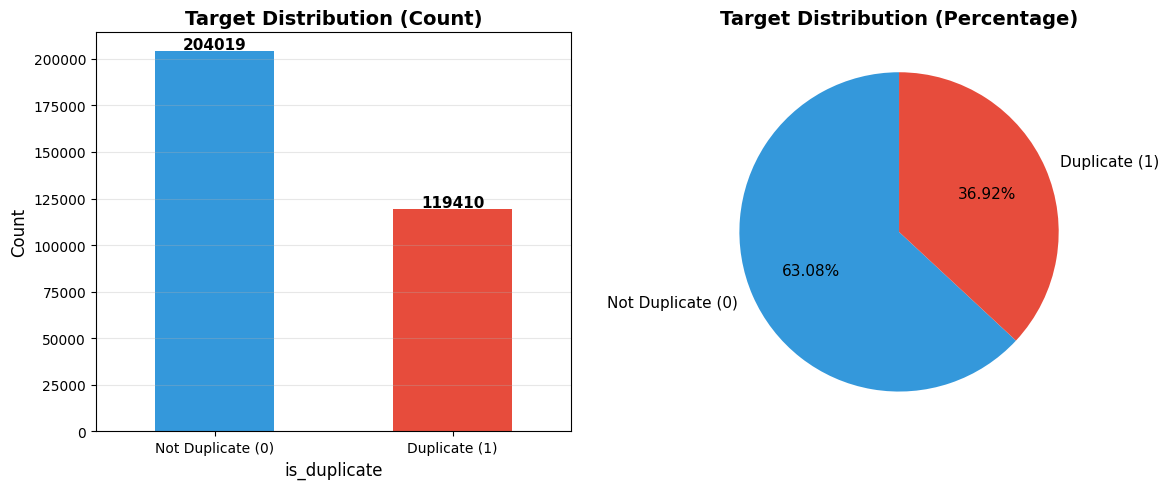

In [15]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = [color1, color2]

# Bar plot
target_dist.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Target Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('is_duplicate', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Not Duplicate (0)', 'Duplicate (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(target_dist.values):
    axes[0].text(i, v + 1000, str(v), ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(
    target_dist.values,
    labels=['Not Duplicate (0)', 'Duplicate (1)'],
    autopct='%1.2f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 11}
)
axes[1].set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Text Length Analysis

In [16]:
train_df['q1_len'] = train_df['question1'].astype(str).apply(len)
train_df['q2_len'] = train_df['question2'].astype(str).apply(len)
train_df['q1_words'] = train_df['question1'].astype(str).apply(lambda x: len(x.split()))
train_df['q2_words'] = train_df['question2'].astype(str).apply(lambda x: len(x.split()))

print("\nCharacter Length:")
print(train_df[['q1_len', 'q2_len']].describe())
print("\nWord Count:")
print(train_df[['q1_words', 'q2_words']].describe())


Character Length:
              q1_len         q2_len
count  323429.000000  323429.000000
mean       59.531761      60.123242
std        29.921286      33.889595
min         1.000000       1.000000
25%        39.000000      39.000000
50%        52.000000      51.000000
75%        72.000000      72.000000
max       623.000000    1169.000000

Word Count:
            q1_words       q2_words
count  323429.000000  323429.000000
mean       10.941715      11.184554
std         5.426282       6.312174
min         1.000000       1.000000
25%         7.000000       7.000000
50%        10.000000      10.000000
75%        13.000000      13.000000
max       125.000000     237.000000


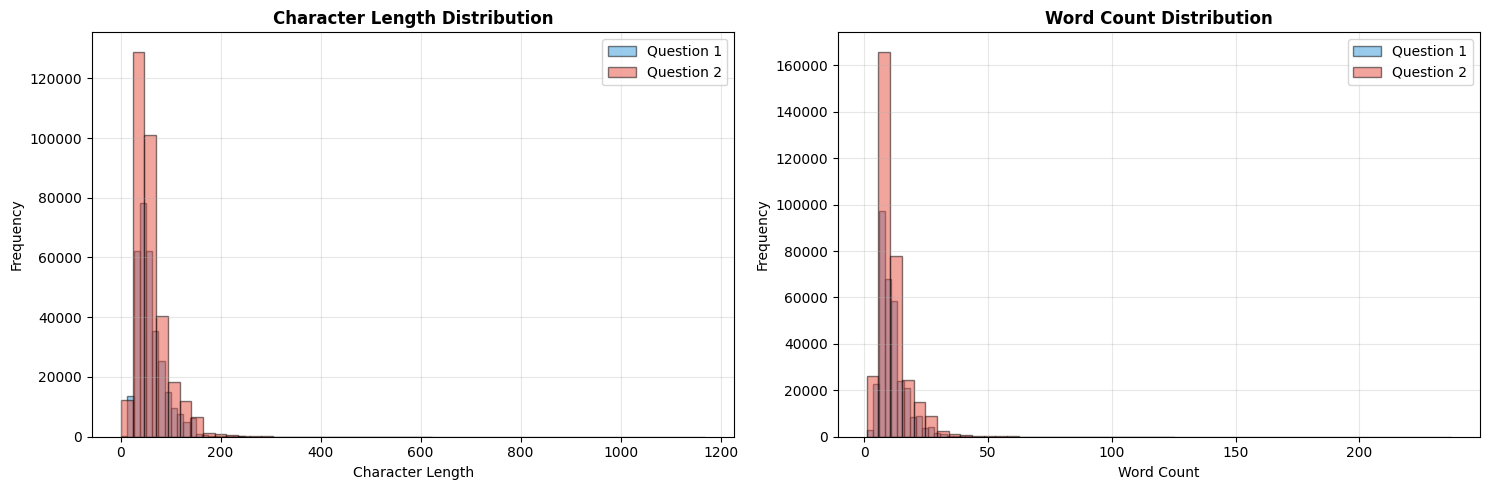

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(train_df['q1_len'], bins=50, alpha=0.5, color=color1, label='Question 1', edgecolor='black')
axes[0].hist(train_df['q2_len'], bins=50, alpha=0.5, color=color2, label='Question 2', edgecolor='black')
axes[0].set_title('Character Length Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Character Length', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count distribution
axes[1].hist(train_df['q1_words'], bins=50, alpha=0.5, color=color1, label='Question 1', edgecolor='black')
axes[1].hist(train_df['q2_words'], bins=50, alpha=0.5, color=color2, label='Question 2', edgecolor='black')
axes[1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].legend()
axes[1].grid(alpha=0.3)

fig.tight_layout()
plt.show()

Both questions in each pair (Q1 and Q2) follow very similar text-length patterns.   
Most questions are 50–120 characters long and leass than 25 words.

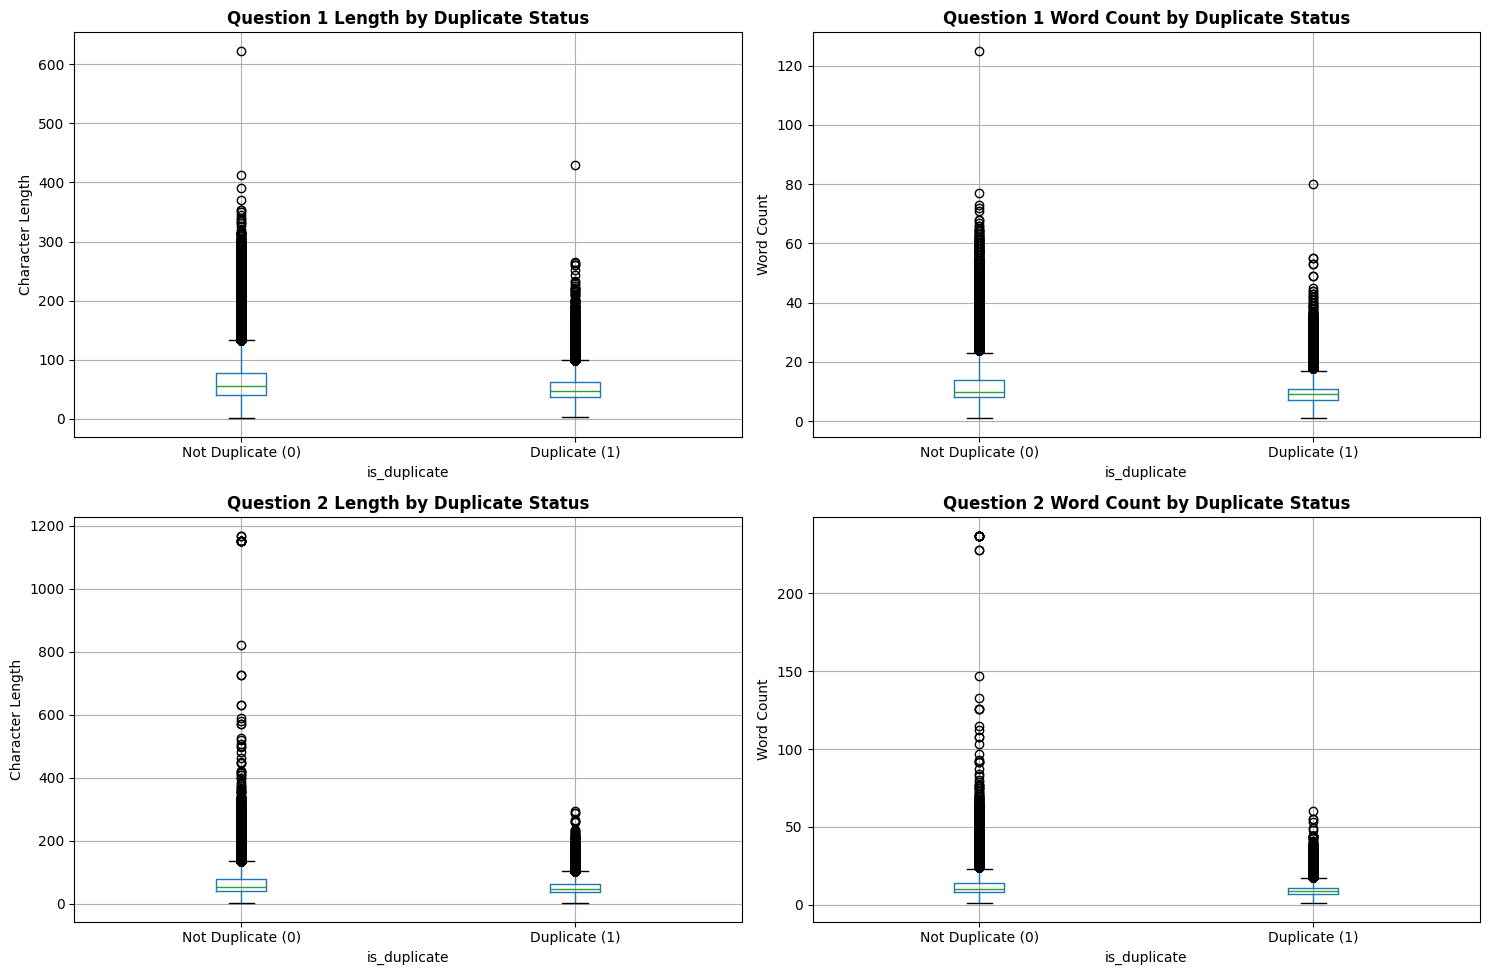

In [18]:
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))

# Question 1
train_df.boxplot(column='q1_len', by='is_duplicate', ax=axes2[0, 0])
axes2[0, 0].set_title('Question 1 Length by Duplicate Status', fontsize=12, fontweight='bold')
axes2[0, 0].set_xlabel('is_duplicate', fontsize=10)
axes2[0, 0].set_ylabel('Character Length', fontsize=10)
plt.sca(axes2[0, 0])
plt.xticks([1, 2], ['Not Duplicate (0)', 'Duplicate (1)'])

train_df.boxplot(column='q1_words', by='is_duplicate', ax=axes2[0, 1])
axes2[0, 1].set_title('Question 1 Word Count by Duplicate Status', fontsize=12, fontweight='bold')
axes2[0, 1].set_xlabel('is_duplicate', fontsize=10)
axes2[0, 1].set_ylabel('Word Count', fontsize=10)
plt.sca(axes2[0, 1])
plt.xticks([1, 2], ['Not Duplicate (0)', 'Duplicate (1)'])

# Question 2
train_df.boxplot(column='q2_len', by='is_duplicate', ax=axes2[1, 0])
axes2[1, 0].set_title('Question 2 Length by Duplicate Status', fontsize=12, fontweight='bold')
axes2[1, 0].set_xlabel('is_duplicate', fontsize=10)
axes2[1, 0].set_ylabel('Character Length', fontsize=10)
plt.sca(axes2[1, 0])
plt.xticks([1, 2], ['Not Duplicate (0)', 'Duplicate (1)'])

train_df.boxplot(column='q2_words', by='is_duplicate', ax=axes2[1, 1])
axes2[1, 1].set_title('Question 2 Word Count by Duplicate Status', fontsize=12, fontweight='bold')
axes2[1, 1].set_xlabel('is_duplicate', fontsize=10)
axes2[1, 1].set_ylabel('Word Count', fontsize=10)
plt.sca(axes2[1, 1])
plt.xticks([1, 2], ['Not Duplicate (0)', 'Duplicate (1)'])

plt.suptitle('')
fig2.tight_layout()
plt.show()

## Common Words Analysis

In [19]:
# Calculate number of common words between question pairs
def common_words(row):
    q1_words = set(str(row['question1']).lower().split())
    q2_words = set(str(row['question2']).lower().split())
    return len(q1_words.intersection(q2_words))

train_df['common_words'] = train_df.apply(common_words, axis=1)

print("COMMON WORDS STATISTICS")
print(train_df.groupby('is_duplicate')['common_words'].describe())

COMMON WORDS STATISTICS
                 count      mean       std  min  25%  50%  75%   max
is_duplicate                                                        
0             204019.0  3.962910  3.205133  0.0  2.0  3.0  5.0  34.0
1             119410.0  5.449242  2.666325  1.0  4.0  5.0  7.0  41.0


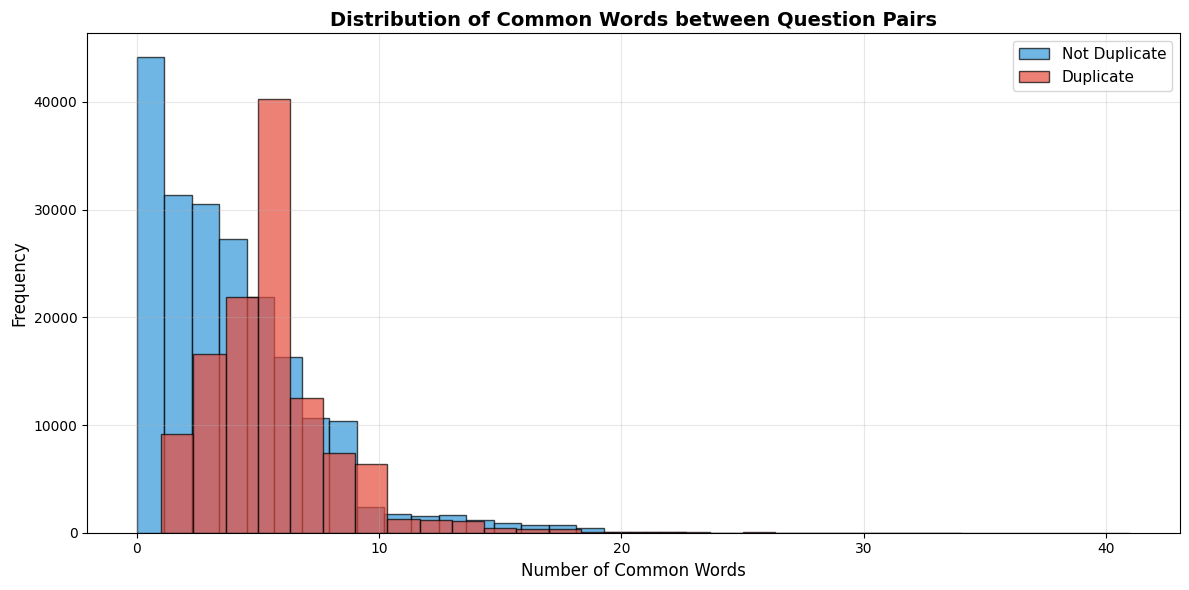

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

train_df[train_df['is_duplicate'] == 0]['common_words'].hist(
    bins=30, alpha=0.7, label='Not Duplicate', color=color1, edgecolor='black', ax=ax
)
train_df[train_df['is_duplicate'] == 1]['common_words'].hist(
    bins=30, alpha=0.7, label='Duplicate', color=color2, edgecolor='black', ax=ax
)

ax.set_title('Distribution of Common Words between Question Pairs', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Common Words', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Duplicates peak around 4–6 common words.   
Non-duplicates mostly peak at 0–2 common words.   
This means that duplicate questions often reuse the same keywords or phrasing.

## Word Frequency Analysis

In [21]:
from collections import Counter

all_words = []
for q in train_df['question1'].astype(str):
    all_words.extend(q.lower().split())
for q in train_df['question2'].astype(str):
    all_words.extend(q.lower().split())

word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

print("TOP 20 MOST FREQUENT WORDS")

for word, count in top_20_words:
    print(f"{word}: {count}")

TOP 20 MOST FREQUENT WORDS
the: 301023
what: 248836
is: 214821
how: 175295
i: 170695
a: 168388
to: 163514
in: 155567
of: 127084
do: 123789
are: 116548
and: 106316
can: 90979
for: 81364
you: 67804
why: 60200
my: 56786
best: 55778
it: 48641
on: 47423


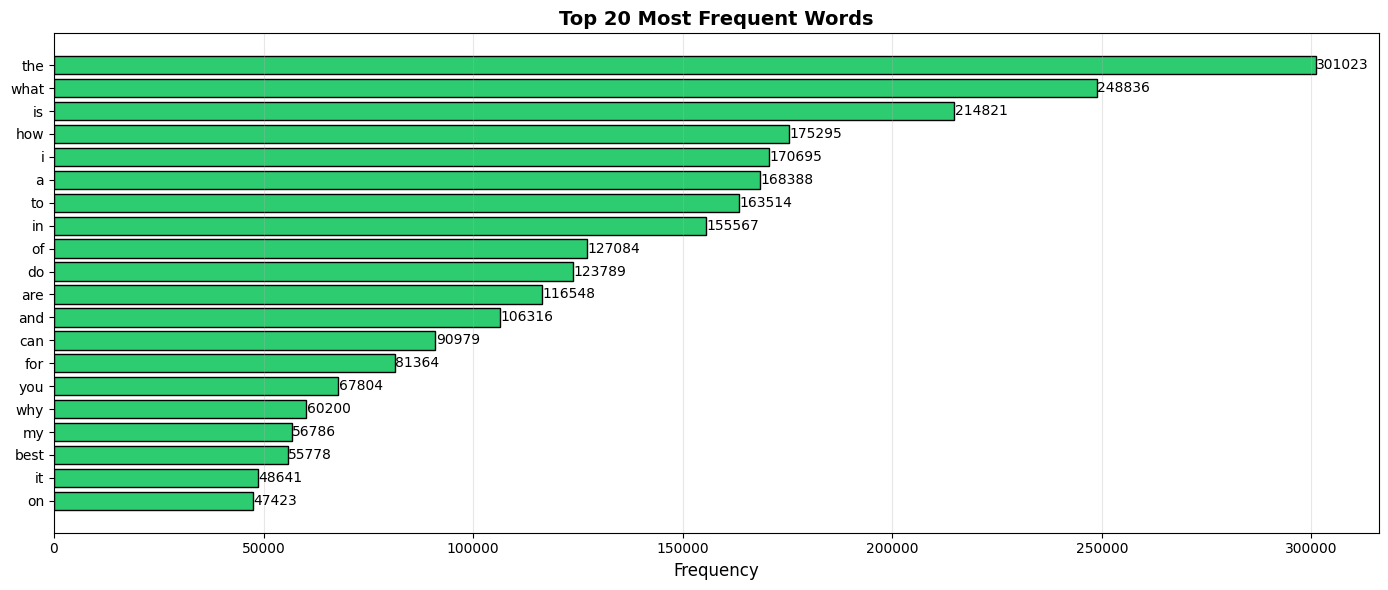

In [22]:
words, counts = zip(*top_20_words)

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.barh(range(len(words)), counts, color='#2ecc71', edgecolor='black')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Top 20 Most Frequent Words', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 100, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

## WordCloud

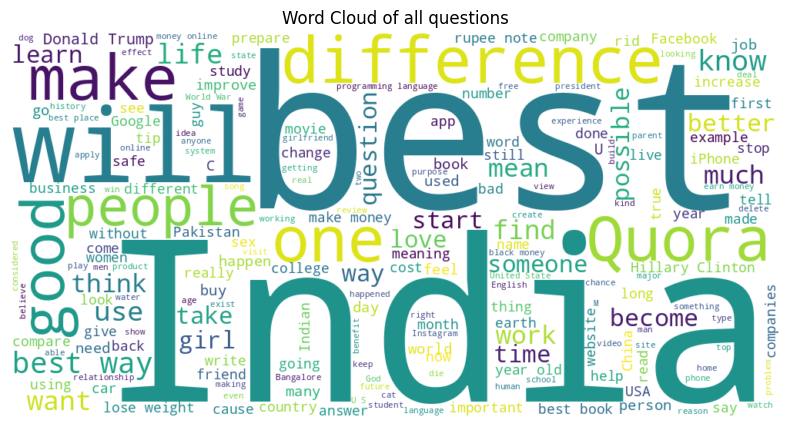

In [23]:
train_qs = train_df['question1'].to_list() + train_df['question2'].to_list()
cloud = WordCloud(width=1000,
                  height=500,
                  background_color='white',
                  random_state=7).generate(' '.join(train_qs))
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of all questions')
plt.show()

## Key Findings Summary

In [24]:
print("KEY FINDINGS SUMMARY")
print(f"\n1. Dataset Size:")
print(f"   - Train: {len(train_df):,} question pairs")
print(f"   - Test: {len(test_df):,} question pairs")

print(f"\n2. Class Distribution:")
print(f"   - Not Duplicate: {target_dist[0]:,} ({target_dist_pct[0]:.2f}%)")
print(f"   - Duplicate: {target_dist[1]:,} ({target_dist_pct[1]:.2f}%)")
print(f"   - Class imbalance ratio: {target_dist[0] / target_dist[1]:.2f}:1")

print(f"\n3. Text Length Statistics:")
print(f"   - Average Q1 length: {train_df['q1_len'].mean():.2f} chars")
print(f"   - Average Q2 length: {train_df['q2_len'].mean():.2f} chars")
print(f"   - Average Q1 words: {train_df['q1_words'].mean():.2f} words")
print(f"   - Average Q2 words: {train_df['q2_words'].mean():.2f} words")

print(f"\n4. Common Words Analysis:")
avg_common_dup = train_df[train_df['is_duplicate'] == 1]['common_words'].mean()
avg_common_non_dup = train_df[train_df['is_duplicate'] == 0]['common_words'].mean()
print(f"   - Average common words (Duplicates): {avg_common_dup:.2f}")
print(f"   - Average common words (Non-duplicates): {avg_common_non_dup:.2f}")
print(f"   - Difference: {avg_common_dup - avg_common_non_dup:.2f}")

print(f"\n5. Vocabulary:")
print(f"   - Total unique words: {len(word_freq):,}")
print(f"   - Total words: {sum(word_freq.values()):,}")

KEY FINDINGS SUMMARY

1. Dataset Size:
   - Train: 323,429 question pairs
   - Test: 80,858 question pairs

2. Class Distribution:
   - Not Duplicate: 204,019 (63.08%)
   - Duplicate: 119,410 (36.92%)
   - Class imbalance ratio: 1.71:1

3. Text Length Statistics:
   - Average Q1 length: 59.53 chars
   - Average Q2 length: 60.12 chars
   - Average Q1 words: 10.94 words
   - Average Q2 words: 11.18 words

4. Common Words Analysis:
   - Average common words (Duplicates): 5.45
   - Average common words (Non-duplicates): 3.96
   - Difference: 1.49

5. Vocabulary:
   - Total unique words: 178,367
   - Total words: 7,156,277
